In [21]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Define classifier and read in weights

In [22]:
data = None
weights_path = "./model/vgg16-cifar.npy"


class Model():
    def __init__(self, vgg16_npy_path=None):
        global data

        if vgg16_npy_path is None:
            path = weights_path

            if os.path.exists(path):
                vgg16_npy_path = path

            else:
                print("VGG16 weights were not found in the project directory!")
                exit(0)

        if data is None:
            data = np.load(vgg16_npy_path, encoding='latin1')
            self.data_dict = data.item()
            print("VGG16 weights loaded")

        else:
            self.data_dict = data.item()

    def build(self, inp):

        self.conv1_1 = self.conv_layer(inp, "conv1_1")
        self.drop1_1 = self.drop_layer(self.conv1_1, 0.3)
        self.conv1_2 = self.conv_layer(self.drop1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.drop2_1 = self.drop_layer(self.conv2_1, 0.4)
        self.conv2_2 = self.conv_layer(self.drop2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.drop3_1 = self.drop_layer(self.conv3_1, 0.4)
        self.conv3_2 = self.conv_layer(self.drop3_1, "conv3_2")
        self.drop3_2 = self.drop_layer(self.conv3_2, 0.4)
        self.conv3_3 = self.conv_layer(self.drop3_2, "conv3_3")

        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.drop4_1 = self.drop_layer(self.conv4_1, 0.4)
        self.conv4_2 = self.conv_layer(self.drop4_1, "conv4_2")
        self.drop4_2 = self.drop_layer(self.conv4_2, 0.4)
        self.conv4_3 = self.conv_layer(self.drop4_2, "conv4_3")

        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.drop5_1 = self.drop_layer(self.conv5_1, 0.4)
        self.conv5_2 = self.conv_layer(self.drop5_1, "conv5_2")
        self.drop5_2 = self.drop_layer(self.conv5_2, 0.4)
        self.conv5_3 = self.conv_layer(self.drop5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, "pool5")

        self.drop6 = self.drop_layer(self.pool5,0.5)
        self.fc1 = self.fc_layer(self.drop6, 'fc1', ac = True, bn = True)
        self.drop1 = self.drop_layer(self.fc1, 0.5)

        logits = self.fc_layer(self.drop1, 'fc2')

        return logits

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name, stride = 1):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, stride, stride, 1], padding='SAME')
            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)
            mean = self.get_mean(name)
            variance = self.get_variance(name)
            offset = self.get_beta(name)
            scale = self.get_gamma(name)
            relu = tf.nn.relu(bias)
            norm = tf.nn.batch_normalization(relu, mean, variance, offset, scale, 1e-20 )
            return norm

    def drop_layer(self, bottom, rate):
        return tf.nn.dropout(bottom, rate)

    def fc_layer(self, bottom, name, ac = False, bn = False):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)
            if (ac):
                fc = tf.nn.relu(fc)
            if (bn):
                mean = self.get_mean(name)
                variance = self.get_variance(name)
                offset = self.get_beta(name)
                scale = self.get_gamma(name)
                fc = tf.nn.batch_normalization(fc, mean, variance, offset, scale, 1e-20 )
            return fc

    def get_mean(self, name):
        return tf.constant(self.data_dict[name][4], name = "mean")

    def get_variance(self, name):
        return tf.constant(self.data_dict[name][5], name = "variance")

    def get_gamma(self, name):
        return tf.constant(self.data_dict[name][2], name = "gamma")

    def get_beta(self, name):
        return tf.constant(self.data_dict[name][3], name = "beta")

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")



In [23]:
'''normalization paramter'''
mean = 120.707
std = 64.15

'''read in image'''
img = cv2.imread('./dog.png').reshape(1, 32, 32, 3)
img_norm = (img - mean)/(std + 1e-7)
label = np.array(5).reshape(1,)

'''define placeholder for image and ground truth'''
x = tf.placeholder(tf.float32, shape = (None,) + (32,32) + (3, ), name = 'data')
gt = tf.placeholder(tf.int32, shape = (None, ), name='gt')

'''define evaluation graph'''
model = Model()
logits_src_img = model.build(x)
preds_src_img = tf.argmax(tf.nn.softmax(logits_src_img), axis = 1)

'''define computation graph at training phase'''
pre_noise = tf.Variable(tf.zeros((1, 32, 32, 3), dtype=tf.float32 ))
noise = 10 * tf.tanh(pre_noise)
x_noise = x + noise

'''clip and round generated examples'''
x_clip = tf.clip_by_value(x_noise, 0, 255)
x_round = x_clip + tf.stop_gradient(x_clip // 1 - x_clip)
x_norm = (x_round - mean )/(std + 1e-7)

'''compute crossentropy loss and accuracy'''
logits = model.build(x_norm)
preds = tf.nn.softmax(logits)
gt_one_hot = tf.one_hot(gt, 10)
loss = tf.losses.softmax_cross_entropy(gt_one_hot, logits) * (-1)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(preds, 1), dtype=tf.int32),
                             tf.cast(tf.argmax(gt_one_hot, 1), dtype = tf.int32)), tf.float32))

placeholders = {
        'data': x,
        'label':label,
        'gt': gt,

    }

VGG16 weights loaded


In [24]:
lr = 1e-2
opt = tf.train.AdamOptimizer(lr)
grads = opt.compute_gradients(loss, [pre_noise])
train = opt.apply_gradients(grads)  

tf.set_random_seed(12345) # ensure consistent results
global_cnt = 0
epoch_start = 0
with tf.Session() as sess:
      
    sess.run(tf.global_variables_initializer()) # init all variables
    print('The prediction of the source image is {}'.format(preds_src_img.eval(feed_dict ={placeholders['data']:img_norm})))
    for epoch in range(epoch_start + 1, 500):
        global_cnt += 1
        feed_dict = {
            placeholders['data']: img,
            placeholders['gt']: label,
        }
        _, accuracy, loss_batch, adv_examples = sess.run([train, acc, loss, x_round],
                                                                       feed_dict=feed_dict)

        if global_cnt % 20 == 0:
            print(
                "e:{}/{}".format(global_cnt, 500),
                'loss: {:.3f}'.format(loss_batch),
                'acc: {:3f}'.format(accuracy),
                    )

    print('The prediction of the adversarial example is {}'.format(preds_src_img.eval(feed_dict ={placeholders['data']:(adv_examples-mean)/(1e-7+std)})))

The prediction of the source image is [5]
e:20/500 loss: -1.607 acc: 0.000000
e:40/500 loss: -2.927 acc: 0.000000
e:60/500 loss: -2.234 acc: 0.000000
e:80/500 loss: -9.705 acc: 0.000000
e:100/500 loss: -3.596 acc: 0.000000
e:120/500 loss: -3.331 acc: 0.000000
e:140/500 loss: -7.691 acc: 0.000000
e:160/500 loss: -3.362 acc: 0.000000
e:180/500 loss: -7.494 acc: 0.000000
e:200/500 loss: -5.571 acc: 0.000000
e:220/500 loss: -3.972 acc: 0.000000
e:240/500 loss: -7.294 acc: 0.000000
e:260/500 loss: -4.638 acc: 0.000000
e:280/500 loss: -8.775 acc: 0.000000
e:300/500 loss: -8.764 acc: 0.000000
e:320/500 loss: -12.099 acc: 0.000000
e:340/500 loss: -11.535 acc: 0.000000
e:360/500 loss: -9.669 acc: 0.000000
e:380/500 loss: -11.080 acc: 0.000000
e:400/500 loss: -10.417 acc: 0.000000
e:420/500 loss: -9.216 acc: 0.000000
e:440/500 loss: -10.755 acc: 0.000000
e:460/500 loss: -5.887 acc: 0.000000
e:480/500 loss: -9.993 acc: 0.000000
The prediction of the adversarial example is [2]


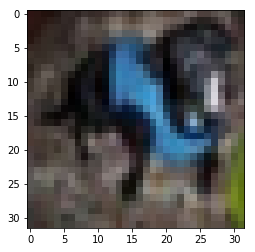

In [14]:
plt.figure()
plt.imshow(img[0].astype('uint8'))
plt.show()

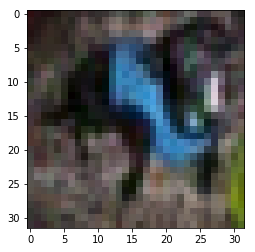

In [17]:
plt.figure()
plt.imshow(adv_examples[0].astype('uint8'))
plt.show()

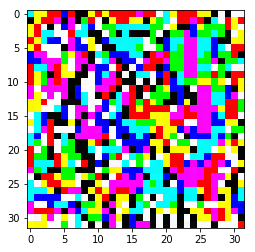

In [20]:
plt.figure()
plt.imshow((adv_examples[0]-img[0]).astype('uint8'))
plt.show()